## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.8]
redice_lr_patient = [10, 25]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0724 11:28:19.861233 26560 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 11:28:19.861233 26560 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 11:28:19.863236 26560 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 11:28:19.916284 26560 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 10


W0724 11:28:20.095446 26560 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 11:28:20.100451 26560 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0724 11:28:20.167512 26560 deprecation.py:323] From c:\users\kehua\.conda\envs\keras\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 72us/step - loss: 1.3715 - acc: 0.5229 - val_loss: 1.5558 - val_acc: 0.4547
Epoch 14/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3510 - acc: 0.5304 - val_loss: 1.5418 - val_acc: 0.4615
Epoch 15/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.3312 - acc: 0.5377 - val_loss: 1.5356 - val_acc: 0.4634
Epoch 16/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.3133 - acc: 0.5448 - val_loss: 1.5305 - val_acc: 0.4610
Epoch 17/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.2945 - acc: 0.5529 - val_loss: 1.5211 - val_acc: 0.4696
Epoch 18/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2778 - acc: 0.5573 - val_loss: 1.5122 - val_acc: 0.4735
Epoch 19/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.2603 - acc: 0.5643 - val_loss: 1.5113 - val_acc: 0.4711
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 4s 90us/step - loss: 2.3813 - acc: 0.2268 - val_loss: 2.1843 - val_acc: 0.2891
Epoch 2/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.8732 - acc: 0.3546 - val_loss: 1.9185 - val_acc: 0.3577
Epoch 3/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.7365 - acc: 0.3958 - val_loss: 1.7997 - val_acc: 0.3857
Epoch 4/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.6563 - acc: 0.4210 - val_loss: 1.7151 - val_acc: 0.4065
Epoch 5/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.6017 - acc: 0.4405 - val_loss: 1.6805 - val_acc: 0.4181
Epoch 6/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.5591 - acc: 0.4557 - val_loss: 1.6466 - val_acc: 0.4255
Epoch 7/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.5223 - acc: 0.4680 - val_loss: 1.6194 - val_acc: 0.4346
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 4s 80us/step - loss: 0.4397 - acc: 0.8686 - val_loss: 1.6112 - val_acc: 0.5135

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24/25
50000/50000 [==============================] - 4s 82us/step - loss: 0.3905 - acc: 0.8926 - val_loss: 1.5531 - val_acc: 0.5292
Epoch 25/25
50000/50000 [==============================] - 4s 80us/step - loss: 0.3693 - acc: 0.9022 - val_loss: 1.5767 - val_acc: 0.5293
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048   

Epoch 9/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.2421 - acc: 0.5683 - val_loss: 1.4857 - val_acc: 0.4789
Epoch 10/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.2141 - acc: 0.5819 - val_loss: 1.4638 - val_acc: 0.4843
Epoch 11/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.1893 - acc: 0.5904 - val_loss: 1.4839 - val_acc: 0.4818
Epoch 12/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1653 - acc: 0.6000 - val_loss: 1.4635 - val_acc: 0.4797
Epoch 13/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.1415 - acc: 0.6086 - val_loss: 1.4441 - val_acc: 0.4881
Epoch 14/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.1217 - acc: 0.6158 - val_loss: 1.4414 - val_acc: 0.4959
Epoch 15/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.1004 - acc: 0.6250 - val_loss: 1.4503 - val_acc: 0.4902
Epoch 16/25
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.8047 - acc: 0.3725 - val_loss: 2.0246 - val_acc: 0.3085
Epoch 2/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.5401 - acc: 0.4554 - val_loss: 2.0928 - val_acc: 0.3026
Epoch 3/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4272 - acc: 0.4956 - val_loss: 2.2619 - val_acc: 0.2628
Epoch 4/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3580 - acc: 0.5201 - val_loss: 4.4752 - val_acc: 0.2209
Epoch 5/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2976 - acc: 0.5393 - val_loss: 1.9813 - val_acc: 0.3226
Epoch 6/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.2499 - acc: 0.5581 - val_loss: 2.0241 - val_acc: 0.3209
Epoch 7/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2073 - acc: 0.5768 - val_loss: 2.2094 - val_ac

50000/50000 [==============================] - 4s 82us/step - loss: 0.6038 - acc: 0.8109 - val_loss: 1.4516 - val_acc: 0.5228
Epoch 23/25
50000/50000 [==============================] - 4s 84us/step - loss: 0.5827 - acc: 0.8213 - val_loss: 1.4589 - val_acc: 0.5196
Epoch 24/25
50000/50000 [==============================] - 4s 79us/step - loss: 0.5666 - acc: 0.8255 - val_loss: 1.5080 - val_acc: 0.5159
Epoch 25/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.5506 - acc: 0.8322 - val_loss: 1.5023 - val_acc: 0.5251
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batc

50000/50000 [==============================] - 4s 77us/step - loss: 1.2651 - acc: 0.5605 - val_loss: 1.5410 - val_acc: 0.4677
Epoch 10/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.2307 - acc: 0.5758 - val_loss: 1.5121 - val_acc: 0.4680
Epoch 11/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1996 - acc: 0.5861 - val_loss: 1.5258 - val_acc: 0.4627
Epoch 12/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.1704 - acc: 0.5989 - val_loss: 1.5211 - val_acc: 0.4606
Epoch 13/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1417 - acc: 0.6087 - val_loss: 1.5025 - val_acc: 0.4712
Epoch 14/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1137 - acc: 0.6215 - val_loss: 1.4898 - val_acc: 0.4765
Epoch 15/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.0893 - acc: 0.6293 - val_loss: 1.4740 - val_acc: 0.4814
Epoch 16/25
50000/50000 [=====================

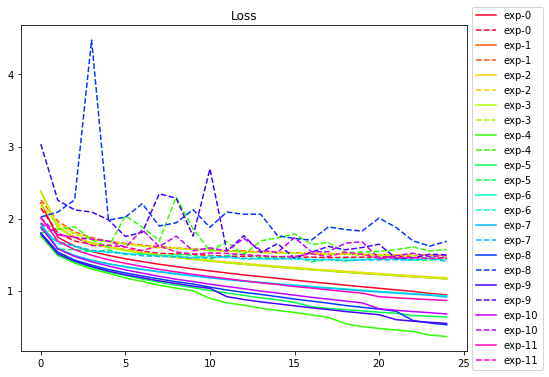

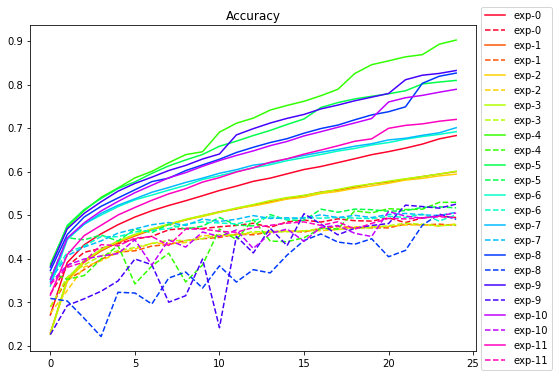

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()